In [1]:
import os
import math as m
from codes_gendrops_py.genSingleDrop import *
from codes_gendrops_py.fit_circle_through_3_points import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pre_process_functions import *
from PIL import Image
import numpy as np

In [ ]:
def remove_needle_centering(img_ori,savepath='./'):
    path=savepath+"cut_needle.png" #%(sigma, volume0, rneedle)

    w_ori,h_ori=img_ori.size

    scaling_ori=300/w_ori # reshape the origin image to weight 100

    w_ori2=int(scaling_ori*w_ori)
    h_ori2=int(scaling_ori*h_ori)

    A=img2bw(ResizeImage(img_ori,w_ori2,h_ori2))

    left_edge=np.zeros(w_ori2)
    right_edge=np.zeros(w_ori2)
    for i in range(h_ori2):
        for j in range(w_ori2):
            if A[i,j-1]>=125 and A[i,j]<125:
                #print('Left position',i,j)
                left_edge[i]=j
            if A[i,j-1]<=125 and A[i,j]>125:
                #print('Right position',i,j)
                right_edge[i]=j

    needle=np.abs(left_edge-right_edge)

    end=0
    #print(needle.shape[0])
    for j in range(needle.shape[0]-1):
        j=j+1
        #print((needle[j]-needle[0])/needle[0])
        if end == 0:
            if abs((needle[j]-needle[0])/needle[0])>0.05:
                stopline=j
                #print(j)
                end=end+1
    #print(stopline)

    img_WON=np.zeros((h_ori2-stopline,w_ori2))
    for i in range(h_ori2):
        if i>=stopline:
            img_WON[i-stopline,:]=A[i,:]
            
    img=Image.fromarray(np.uint8(img_WON))
    img.save(path)
    return path

In [ ]:
def cost_v3(img_ori,img_syn,width=100,output=0):
    '''
    input:              
    x:                the origin point of synthetic image
    img_syn,img_ori:    the images that need to calculate the cost 
                        should be valued by 'Image.open(path)'
    K:                  the scaling of synthethic image
    output: 0 -->lost, 1-->C, else C,lost
    '''
    w_ori,h_ori=img_ori.size
    w_syn,h_syn=img_syn.size
    

    scaling_ori=width/w_ori # reshape the origin image to width 100
    w_ori2=int(scaling_ori*w_ori)
    h_ori2=int(scaling_ori*h_ori)
    scaling_syn=K*scaling_ori
    w_syn2=int(scaling_syn*w_syn)
    h_syn2=int(scaling_syn*h_syn)
    x=int(x)

    A=img2bw(ResizeImage(img_ori,w_ori2,h_ori2))
    one=np.ones((w_ori2-h_ori2,w_ori2))*255
    A=np.row_stack((A,one))


    B=img2bw(ResizeImage(img_syn,w_syn2,h_syn2))
    C=np.zeros((w_ori2,w_ori2))

    for i in range (w_ori2): # h
        for j in range(w_ori2): # w
            #print (h_ori2,w_ori2)
            #print(i,j)
            if j < x or j-x >= w_syn2 or i >= h_syn2 :
                 C[i,j]=A[i,j]
            else:
                if  A[i,j]==B[i,j-x]: # B[i-y,j-x]
                    C[i,j]=255
                else:
                    C[i,j]=0
    
    # pixel that same(T) different(F) and drop area
    t=0; f=0; 
    #drop_ori=0; drop_gen=0 
    for i in range (w_ori2):
        for j in range(h_ori2):
            if C[i,j]==0:
                f=f+1
            else:
                t=t+1
    lost=f/max(w_ori2*h_ori2,w_syn2*h_syn2)
    accurancy=1-lost

    if output == 0:
        return lost
    elif output == 1:
        return C
    else:
        return C,lost

## Definite the obtimize funciton

'.//s75.00_v20.00_rn1.00.jpg'

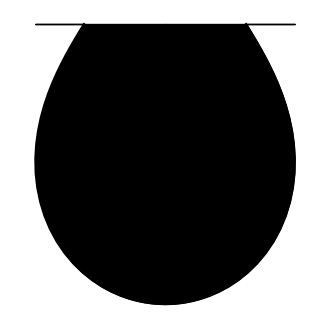

In [2]:
def obtimize_v3(sv,path_ori=os.path.abspath('./images_experiment/220304_miliq_T17.7_S73.04.png'),savepath=os.path.abspath('./images_gen/')):
    sigma=sv[0]
    v0=sv[1]

    # import the img_ori
    path_ori=os.path.abspath('./images_experiment/220304_miliq_T17.7_S73.04.png')
    path_ori=remove_needle(Image.open(path_ori))
    
    